In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

###  MicroGrad demo

In [2]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

In [2]:
np.random.seed(1337)
random.seed(1337)

In [ ]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = ((y*2 - 1) > 0).astype(int) # make y be -1 or 1
print(y, len(y))
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [ ]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

In [13]:
a= Value(2.0)
b = Value(-3.0)
a + b 

Value(data=-1.0, grad=0)

In [17]:
# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=1.1281637884148759, grad=0) 0.5


In [ ]:
# optimization
for k in range(100):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

(-1.548639298268643, 1.951360701731357)

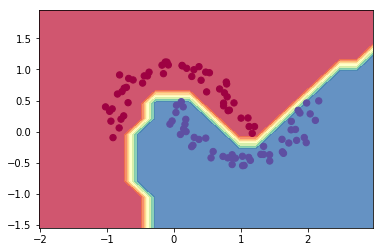

In [ ]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())


# MNIST with macrograd

In [2]:
# don't even use pytorch

import torch  # install pytorch and then download MNIST
from torchvision import datasets, transforms

# transform example said to do: https://github.com/pytorch/examples/blob/main/mnist/main.py#L7
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [ ]:
# flatten the images
def flatten_images(images_array):
    prod = 1
    shape_of_arr = list(images_array.shape)
    for i in range(1, len(shape_of_arr)):
        prod *= shape_of_arr[i]
    return images_array.reshape(images_array.shape[0], prod)

mnist_trainset.data = flatten_images(mnist_trainset.data)
mnist_testset.data = flatten_images(mnist_testset.data)

print(f"{len(mnist_trainset) = }")
print(f"{len(mnist_testset) = }")
print(f"{mnist_trainset.data.shape = }")
print(f"{mnist_trainset[0] = }")
print(f"{mnist_trainset.targets[0] = }")
print(f"{mnist_testset.data.shape = }")

b_s = 825

train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=b_s, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=b_s, shuffle=False)




In [3]:
from macrograd.engine import Tensor
from macrograd.nn import Layer, MLP_macro

In [ ]:
model = MLP_macro(2, [10, 10, 10, 2]) # 2-layer neural network
# print(model)
# print("number of parameters", len(model.parameters()))

In [5]:
np.random.seed(1337)
random.seed(1337)

In [ ]:
# before: b_s = 840, layers: [16, 10, 10]
model = MLP_macro(28*28, [16, 10, 10]) # 2-layer neural network
# print(model)
# print(model)
# print("number of parameters", len(model.parameters()))

In [5]:
def loss(probs, y_batch):
    # get the predicted classes
    losses = probs.cross_entropy_loss(y_batch)
    
    # L2 regularization
    # alpha = 1e-4
    # reg_loss = alpha * sum([(p.array*p.array).sum() for p in model.parameters()])
    total_loss = losses # + Tensor(reg_loss)
    
    # also get accuracy
    m = len(y_batch.array)
    scores = np.argmax(probs.array, axis = 1, keepdims=True)
    accuracy = np.sum(y_batch.array == scores)/ len(y_batch.array)
    # accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(y_batch.array, scores.array)]
    return total_loss, accuracy


In [6]:
def train(X, y, epochs, batch_size):
    for k in range(epochs):
        # X_batch_array = mnist_trainset.data[: 64]
        # y_batch_array = mnist_trainset.targets[: 64]
        # for images, labels in train_loader:
        #     X_batch_array = images.numpy()
        #     X_batch_array = flatten_images(X_batch_array)
        #     y_batch_array = labels.numpy()
        #     y_batch_array = flatten_images(y_batch_array)

        # X_batch = Tensor(X_batch_array)
        # y_batch = Tensor(y_batch_array)
            # inline DataLoader :)
        if batch_size is None:
            X_batch, y_batch = X, y
        else:
            ri = np.random.permutation(X.shape[0])[:batch_size]
            X_batch, y_batch = X[ri], y[ri]
        inputs = Tensor(np.array([xrow for xrow in X_batch]))
        y_batch = Tensor(np.array(y_batch).reshape(-1, 1))

        # print(f"{inputs.array.shape = }")
        # print(f"{y_batch.array.shape = }")

        # forward the model to get scores
        scores = model(inputs)
        # forward
        total_loss, acc = loss(scores, y_batch)
        
        # backward
        model.zero_grad()
        total_loss.backward()

        # update (sgd)
        # finetune the learning rate. harcoded decay: at step 30, decreasee the lr. at step 70 decrease lr. 
        # this way you force the model to local minimum
        learning_rate = 0.001
        for p in model.parameters():
            # print(f"{np.linalg.norm(p.grad) = }")
            p.array -= learning_rate * 1/ batch_size * p.grad
        
        if k % 10 == 0:
            preds = np.argmax(scores.array, axis = 1)
            print(f"preds are {preds.reshape(1, -1)}, should be {y_batch.array.reshape(1, -1)}")
            print(f"step {k} loss {total_loss.array}, accuracy {acc*100}%")
train(X, y, 60, 16)


preds are [[1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1]], should be [[0 1 1 1 0 0 1 0 0 0 0 0 1 1 0 0]]
step 0 loss 0.6568939328297059, accuracy 68.75%
preds are [[1 1 1 1 1 1 0 0 1 1 0 0 1 1 1 1]], should be [[1 1 1 0 0 1 1 0 1 1 0 0 0 1 1 1]]
step 10 loss 0.5329833282174088, accuracy 75.0%
preds are [[0 0 0 0 0 1 0 1 1 1 1 0 1 1 1 1]], should be [[0 0 1 0 0 1 0 1 0 0 1 0 1 1 1 1]]
step 20 loss 0.5939082311293535, accuracy 81.25%
preds are [[1 1 0 0 1 0 1 0 1 0 0 0 1 1 1 1]], should be [[1 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0]]
step 30 loss 0.7544101077502428, accuracy 50.0%
preds are [[1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1]], should be [[1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1]]
step 40 loss 0.7844677259268933, accuracy 50.0%
preds are [[0 1 1 0 0 0 1 1 0 1 1 1 1 1 1 0]], should be [[0 1 1 0 0 0 0 1 0 1 1 1 1 1 0 0]]
step 50 loss 0.4606521804444407, accuracy 87.5%


In [8]:
def train(epochs):
    for k in range(epochs):
        # X_batch_array = mnist_trainset.data[: 64]
        # y_batch_array = mnist_trainset.targets[: 64]
        # i = 0
        for images, labels in train_loader:
            # i += 1
            # if i == 55 and k == 8:
            #     import pdb; pdb.set_trace()
            # print(f"{i =} and {k = }")
            X_batch_array = images.numpy()
            X_batch_array = flatten_images(X_batch_array)
            y_batch_array = labels.numpy()
            y_batch_array = flatten_images(y_batch_array)

            X_batch = Tensor(X_batch_array)
            y_batch = Tensor(y_batch_array)
            # inline DataLoader :)
            # if batch_size is None:
            #     X_batch, y_batch = X, y
            # else:
            #     ri = np.random.permutation(X.shape[0])[:batch_size]
            #     X_batch, y_batch = X[ri], y[ri]
            # inputs = Tensor(np.array([xrow for xrow in X_batch]))
            # y_batch = Tensor(np.array(y_batch).reshape(-1, 1))

            # print(f"{inputs.array.shape = }")
            # print(f"{y_batch.array.shape = }")

            # forward the model to get scores
            inputs = X_batch
            scores = model(inputs)

            # forward
            total_loss, acc = loss(scores, y_batch)
            
            # backward
            model.zero_grad()
            total_loss.backward()

            # update (sgd)
            # finetune the learning rate. harcoded decay: at step 30, decreasee the lr. at step 70 decrease lr. 
            # this way you force the model to local minimum
            learning_rate = 0.0001
            batch_size = scores.array.shape[0]
            for p in model.parameters():
                # print(f"{np.linalg.norm(p.grad) = }")
                p.array -= learning_rate * 1/ batch_size * p.grad
        
        if k % 10 == 0:
            preds = np.argmax(scores.array, axis = 1, keepdims=True)
            # print(f"preds are {preds.reshape(1, -1)}, should be {y_batch.array.reshape(1, -1)}")
            print(f"step {k} loss {total_loss.array}, accuracy {acc*100}%")
train(30)


step 0 loss 2.6028102974963074, accuracy 12.916666666666668%
step 10 loss 2.7473055628969463, accuracy 10.416666666666668%
step 20 loss 2.8737675771514555, accuracy 14.166666666666666%


In [8]:
def train(epochs):
    for k in range(epochs):
        # X_batch_array = mnist_trainset.data[: 64]
        # y_batch_array = mnist_trainset.targets[: 64]
        i = 0
        for images, labels in train_loader:
            i += 1
            # if i == 241 and k == 3:
            #     import pdb; pdb.set_trace()
            # print(f"{i =} and {k = }")
            X_batch_array = images.numpy()
            X_batch_array = flatten_images(X_batch_array)
            y_batch_array = labels.numpy()
            y_batch_array = flatten_images(y_batch_array)

            X_batch = Tensor(X_batch_array)
            y_batch = Tensor(y_batch_array)
            # inline DataLoader :)
            # if batch_size is None:
            #     X_batch, y_batch = X, y
            # else:
            #     ri = np.random.permutation(X.shape[0])[:batch_size]
            #     X_batch, y_batch = X[ri], y[ri]
            # inputs = Tensor(np.array([xrow for xrow in X_batch]))
            # y_batch = Tensor(np.array(y_batch).reshape(-1, 1))

            # print(f"{inputs.array.shape = }")
            # print(f"{y_batch.array.shape = }")

            # forward the model to get scores
            inputs = X_batch
            scores = model(inputs)

            # forward
            total_loss, acc = loss(scores, y_batch)
            
            # backward
            model.zero_grad()
            total_loss.backward()

            # update (sgd)
            # finetune the learning rate. harcoded decay: at step 30, decreasee the lr. at step 70 decrease lr. 
            # this way you force the model to local minimum
            learning_rate = 0.0001
            batch_size = scores.array.shape[0]
            for p in model.parameters():
                # print(f"{np.linalg.norm(p.grad) = }")
                p.array -= learning_rate * 1/ batch_size * p.grad
        
        if k % 10 == 0:
            preds = np.argmax(scores.array, axis = 1, keepdims=True)
            # print(f"preds are {preds.reshape(1, -1)}, should be {y_batch.array.reshape(1, -1)}")
            print(f"step {k} loss {total_loss.array}, accuracy {acc*100}%")
train(40)


step 0 loss 2.50002134578522, accuracy 14.399999999999999%
step 10 loss 2.7324889299668187, accuracy 10.2%
step 20 loss 2.789750624078462, accuracy 12.6%
step 30 loss 4.312672092820764, accuracy 14.2%


In both examples above model is becoming less sure although accuracy is increasing. Potential overfitting.

Model, though, works great for make_moons dataset example:

In [7]:
def train(X, y, epochs, batch_size):
    for k in range(epochs):
        # X_batch_array = mnist_trainset.data[: 64]
        # y_batch_array = mnist_trainset.targets[: 64]
        # for images, labels in train_loader:
        #     X_batch_array = images.numpy()
        #     X_batch_array = flatten_images(X_batch_array)
        #     y_batch_array = labels.numpy()
        #     y_batch_array = flatten_images(y_batch_array)

        # X_batch = Tensor(X_batch_array)
        # y_batch = Tensor(y_batch_array)
            # inline DataLoader :)
        if batch_size is None:
            X_batch, y_batch = X, y
        else:
            ri = np.random.permutation(X.shape[0])[:batch_size]
            X_batch, y_batch = X[ri], y[ri]
        inputs = Tensor(np.array([xrow for xrow in X_batch]))
        y_batch = Tensor(np.array(y_batch).reshape(-1, 1))

        # print(f"{inputs.array.shape = }")
        # print(f"{y_batch.array.shape = }")

        # forward the model to get scores
        scores = model(inputs)
        # forward
        total_loss, acc = loss(scores, y_batch)
        
        # backward
        model.zero_grad()
        total_loss.backward()

        # update (sgd)
        # finetune the learning rate. harcoded decay: at step 30, decreasee the lr. at step 70 decrease lr. 
        # this way you force the model to local minimum
        learning_rate = 0.001
        for p in model.parameters():
            # print(f"{np.linalg.norm(p.grad) = }")
            p.array -= learning_rate * 1/ batch_size * p.grad
        
        if k % 10 == 0:
            # print(f"preds are {scores.array.reshape(1, -1)}, should be {y_batch.array.reshape(1, -1)}")
            print(f"step {k} loss {total_loss.array}, accuracy {acc*100}%")
train(X, y, 40, 16)


step 0 loss 0.7444832666430352, accuracy 62.5%
step 10 loss 0.574332805878023, accuracy 87.5%
step 20 loss 0.5947291601337513, accuracy 87.5%
step 30 loss 0.6764941334948852, accuracy 75.0%


In [ ]:

import numpy as np
Y = Tensor(np.array([1, 0, 2, 1, 2]).reshape(-1, 1))
p = np.array([[0.7, 0.2, 0.1],
              [0.3, 0.5, 0.2],
              [0.6, 0.1, 0.3], 
              [0.4, 0.5, 0.1],
              [0.1, 0.2, 0.7]
              ])
print(f"{p = }")
# y_batch = Y
# scores = np.argmax(p, axis = 1, keepdims=True)
# print(scores.shape)
# accuracy = np.sum(y_batch.array == scores)/ len(y_batch.array)
# print(accuracy)
# m = Y.array.shape[0]
# labels = np.zeros((m, p.shape[1])).astype(int)
# labels[range(m), Y.array.flatten()] = 1
# print(p - labels)
# # formula for cross_entropy_loss
# loss = labels * np.log(p)
# loss = -np.sum(loss) / m
# print(loss)
# scores = np.argmax(p, axis = 1, keepdims=True)
# accuracy = np.sum(Y.array == scores)/ len(Y.array)
# print(accuracy)
# # get one_hot encoding of labels

# m = Y.array.shape[0]
# labels = np.zeros((m, p.shape[1])).astype(int)
# labels[range(m), Y.array.flatten()] = 1

# # formula for cross_entropy_loss
# loss = labels * np.log(p)
# loss = -np.sum(loss) / m
# print(loss)

# m = Y.array.shape[0]

# # get one_hot encoding of labels
# labels = np.zeros((m, p.shape[1])).astype(int)
# labels[range(m), Y.array.flatten()] = 1

# # formula for cross_entropy_loss
# loss = labels * np.log(p)
# loss = -np.sum(loss) / m
# print(f"{loss = }")

sum_elems = 0
for row in range(m):
    sum_elems += np.log(p[row][Y.array[row]])
print(f"{sum_elems / m} = ")

print(loss == -sum_elems / m)


# self has already recieved softmax
# p[range(m), labels.array] does p[i][tru_labels[i]] for every row i
# log_likelihood = -np.log(p[range(m), labels])
# loss = np.sum(log_likelihood) / m
# print(loss)